## Iskanje strukture v podatkih

Podatkovno rudarjenje, naloga, `11.04.2022`
**`MATIC KNEZ`**

**Zaradi odsotnosti (tekmovanje Hekaton - fakulteta FE) v tednu od 28.03. do 3.04 sem z asistentom Rokom Gomiščkom zmenjen, da lahko 2. domačo nalogo oddam z 1 tedensko zamudo.**

Z modeliranjem skušamo poiskati strukturo v podatkih. Z metodami nenadzorovanga modeliranja skušamo poiskati skupine podobnih podatkov oz. skupine primerov.

V nalogi boste uporabili modeliranje verjetnostnih porazdelitev za iskanje osamelcev ter metode za iskanje skupin podobnih primerov (gručenje).

### Podatki

Opis podatkovne zbirke MovieLens ostaja enak prvi nalogi.

Najprej pripravimo podatke.

Vse vrstice (ocene) iz datoteke ratings.csv shranimo v tabelo - raiting_data.

Vse vrstice (filme) iz datoteke movies.csv shranimo v slovar - movies_data.

In [1]:
from csv import DictReader
import warnings
warnings.filterwarnings("ignore")
import numpy as np
np.set_printoptions(suppress=True,
   formatter={'float_kind':'{:0.3f}'.format})

In [2]:
# raiting_data (list)
# user id, movie id, raiting, date

raiting_data = []
reader = DictReader(open('podatki/ml-latest-small/ratings.csv', 'rt', encoding='utf-8'))
for row in reader:
    tab = []
    tab.append(row["userId"])
    tab.append(row["movieId"])
    tab.append(row["rating"])
    tab.append(row["timestamp"])
    raiting_data.append(tab) 

raiting_data = np.asarray(raiting_data, dtype=np.float64) # convert to numpy array 
raiting_data.shape

(100004, 4)

In [3]:
# movies_data (dictionary) 
# key = movie id
# value = title, genre

movies_data = dict()
reader = DictReader(open('podatki/ml-latest-small/movies.csv', 'rt', encoding='utf-8'))
for row in reader:
    movies_data[float(row["movieId"])] = (row["title"], row["genres"])
movies_data[1]  

('Toy Story (1995)', 'Adventure|Animation|Children|Comedy|Fantasy')

### Vprašanja

Z uporabo principov, ki ste jih spoznali na vajah in predavanjih, odgovorite na
spodnja vprašanja. Pri vsakem vprašanju dobro premislite, na kakšen način boste
najbolje podali, prikazali oz. utemeljili odgovor. Bistven del so odgovori na
vprašanja in ne toliko implementacija vaše rešitve.

#### 1. Iskanje osamelcev (50%) 
O ocenah katerih filmov so si uporabniki najmanj enotni? Povedano drugače, za katere filme so pripadajoče ocene najbolj razpršene?

Formuliraj problem kot modeliranje verjetnostne porazdelitve. Premisli o naslednjih vprašanjih, naredi ustrezne poizkuse in odgovori.

#### 1.1. vprašanje:

Katera je ustrezna naključna spremenljivka (količina) v podatkih, ki odgovarja na vprašanje? 

Odgovor:

Za nakjlučno spremenljvko bom izbral **varianco** ocen posameznega filma. 

Varianca = mera razpršenosti (odstopanja od povprečja).

Varianca ocen filma nam bo povedala kako so ocene **razpršene** (kje so uporabniki najmanj enotni).

Manj kot je odstopanja ocen (razpršenosti ocen) manjša bo varianca.

#### 1.2. vprašanje:
Nariši njeno porazdelitev, npr., s pomočjo histograma.

Odgovor:

Izračunamo varianco za vsak film.

varianca = sum((ocene - povprecje)^2) / len(ocene)

Izrišemo varianco v odvisnosti od stevilo filmov s to varianco (hist, bins)

In [4]:
# v tabelo shranimo vse filme, ki so bili v datoteki rating ocenjeni 
movies = [movie for movie in raiting_data[:, 1]]
# ker so posamezni filmi bili ocenjeni veckrat, izlocimo duplikate
movies = np.unique(movies)
print("Vsi ocenjeni filmi: ", movies.shape[0])

def stevilo_ocen(movie):
    ocene = raiting_data[raiting_data[:, 1] == movie, 2]
    return ocene.shape[0]

#mean = np.mean(raiting_data[raiting_data[:, 1] == movie, 2])
def povprecje_filma(movie):
    ocene = raiting_data[raiting_data[:, 1] == movie, 2]
    povprecje = sum(ocena for ocena in ocene)
    return povprecje / ocene.shape[0]

#var = np.var(raiting_data[raiting_data[:, 1] == movie, 2])
def varianca_filma(movie):
    povp = povprecje_filma(movie)
    ocene = raiting_data[raiting_data[:, 1] == movie, 2]
    varianca = sum((ocena - povp) ** 2  for ocena in ocene)
    return varianca / ocene.shape[0]

print("Povpreceje filma 1: ", povprecje_filma(1))
print("Varianca filma 1: ", varianca_filma(1))

Vsi ocenjeni filmi:  9066
Povpreceje filma 1:  3.8724696356275303
Varianca filma 1:  0.9159222409808391


Napisali smo funkcije, ki nam bodo pomagale pri izračunu variance za posamezen film.

In [5]:
# izracunamo variance za vse filme
movie_ratings = [(varianca_filma(movie), povprecje_filma(movie), stevilo_ocen(movie), movie) for movie in movies]
print("Film 1:")
print("Varinca: ", "{:.2f}".format(movie_ratings[0][0]), 
      "Povprecje: ", "{:.2f}".format(movie_ratings[0][1]), 
      "St. ocen", movie_ratings[0][2])

Film 1:
Varinca:  0.92 Povprecje:  3.87 St. ocen 247


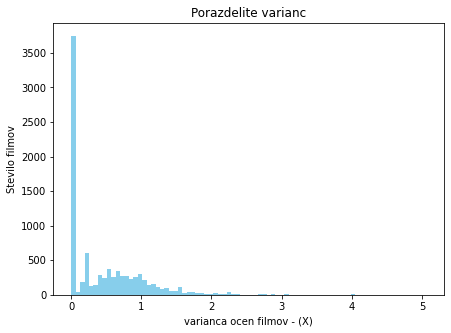

In [6]:
%matplotlib inline
import matplotlib.pyplot as plt

np_movie_ratings = np.asarray(movie_ratings)

plt.figure(figsize=(7, 5))
plt.hist(np_movie_ratings[:, 0], bins=80, color = "skyblue")

plt.title("Porazdelite varianc")
plt.ylabel("Stevilo filmov")
plt.xlabel("varianca ocen filmov - (X)");
plt.show()

Nekaj ni vredu, iz grafa razberemo, da imamo veliko filmov z varianco 0.

Film bi lahko imel varianco 0 v primeru, da ima 1 samo oceno.

Če imamo 1 samo oceno, pomeni da je povprecna vrednost enaka tej oceni, ko jih med seboj odstejemo dobimo 0 -> varianca = 0.

Da se prepričamo ali to drži uredimo seznam varianc in izpisemo 10 filmov z najnižjo varianco in št. ocen.

In [7]:
sorted_ratings = sorted(movie_ratings)

for movie in sorted_ratings[:10]:
    print("Varianca: ", "{:.2f}".format(movie[0]), "Stevilo ocen: ", movie[2], "Movie: ", movies_data[movie[3]][0])

Varianca:  0.00 Stevilo ocen:  1 Movie:  Santa with Muscles (1996)
Varianca:  0.00 Stevilo ocen:  1 Movie:  Merry War, A (1997)
Varianca:  0.00 Stevilo ocen:  1 Movie:  Whiteboyz (1999)
Varianca:  0.00 Stevilo ocen:  1 Movie:  Catfish in Black Bean Sauce (2000)
Varianca:  0.00 Stevilo ocen:  1 Movie:  Killer Shrews, The (1959)
Varianca:  0.00 Stevilo ocen:  1 Movie:  Horrors of Spider Island (Ein Toter Hing im Netz) (1960)
Varianca:  0.00 Stevilo ocen:  1 Movie:  Arthur 2: On the Rocks (1988)
Varianca:  0.00 Stevilo ocen:  1 Movie:  Worth Winning (1989)
Varianca:  0.00 Stevilo ocen:  1 Movie:  Vamp (1986)
Varianca:  0.00 Stevilo ocen:  1 Movie:  Funny Lady (1975)


Prav smo predvidevali, vsi filmi z varianco 0 imajo samo 1 oceno.

To težavo odpravimo, tako da dodajamo na seznam samo filme, ki imajo vec kot 10 ocen.

In [8]:
# izracunamo variance za vse filme, ki imajo vec kot 10 ocen.

movie_ratings = [(varianca_filma(movie), povprecje_filma(movie), stevilo_ocen(movie), movie) for movie in movies if stevilo_ocen(movie) > 15]
sorted_ratings = sorted(movie_ratings)

for movie in sorted_ratings[:10]:
    print("Varianca: ", "{:.2f}".format(movie[0]), "Stevilo ocen: ", movie[2], "Movie ID: ", movies_data[movie[3]][0])

Varianca:  0.12 Stevilo ocen:  16 Movie ID:  Key Largo (1948)
Varianca:  0.15 Stevilo ocen:  24 Movie ID:  Frighteners, The (1996)
Varianca:  0.19 Stevilo ocen:  24 Movie ID:  Smoke (1995)
Varianca:  0.19 Stevilo ocen:  16 Movie ID:  You Can Count on Me (2000)
Varianca:  0.21 Stevilo ocen:  35 Movie ID:  Muppet Movie, The (1979)
Varianca:  0.22 Stevilo ocen:  18 Movie ID:  Diabolique (1996)
Varianca:  0.25 Stevilo ocen:  17 Movie ID:  Captain America: The Winter Soldier (2014)
Varianca:  0.25 Stevilo ocen:  18 Movie ID:  Hellboy II: The Golden Army (2008)
Varianca:  0.25 Stevilo ocen:  29 Movie ID:  Harry Potter and the Half-Blood Prince (2009)
Varianca:  0.26 Stevilo ocen:  26 Movie ID:  Hurt Locker, The (2008)


Vidimo, da nimamo več filmov z varianco 0.

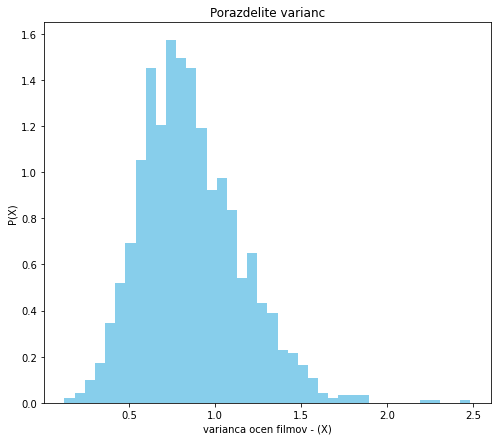

In [9]:
np_movie_ratings = np.asarray(sorted_ratings)

plt.figure(figsize=(8, 7))
plt.hist(np_movie_ratings[:, 0], bins=40, density=True, color = "skyblue")

plt.title("Porazdelite varianc")
plt.ylabel("P(X)")
plt.xlabel("varianca ocen filmov - (X)");
plt.show()

Podatke smo pripravili in jih sortirali po vrsti po varianci.

Porazdelitev varianc nato predstavimo s pomocjo histograma. Na X - osi imamo variance ocen filmov.

Porazdelitev zgleda vredu, opazimo, da imamo največ filmov z varianco od 0.5 do 1.2. 

Nekaj filmov pa ima varianco tudi do 2.5.

#### 1.3. vprašanje:

Ali porazdelitev spominja na kakšno znano porazdelitev? Ali je porazdelitev morda normalna ali katera druga? 

Odgovor:

Porazdelitev spominja na normalno (Gaussovo), preverimo ali je vzorec normalno porazdeljen.

Za normalno porazdelitev potrebujemo 2 parametra - sredino in varianco. Parametre ocenimo iz vzorca.

mu = sredina (povprečje)

sigma = varianca (odstopanje)

In [10]:
# Za normalno porazdelitev izracunamo oceno za parametre: 
# - sredina (povprecna vrednost)
# - varianca (odstopanje od sredine)


variance = np_movie_ratings[:, 0]
n = variance.shape[0]
# sredina = povprecje 
mu_fit = np.mean(variance) 
# varianca (odstopanje)
sigma2_fit = (n-1)/n * np.var(variance) 


print("Sredina: ", mu_fit)
print("Varianca: ", sigma2_fit)

Sredina:  0.8594626805474678
Varianca:  0.08454927057933935


S funkcije multivariate_normal dobimo ocenjeno normalno porazdelitev glede na vzorec.

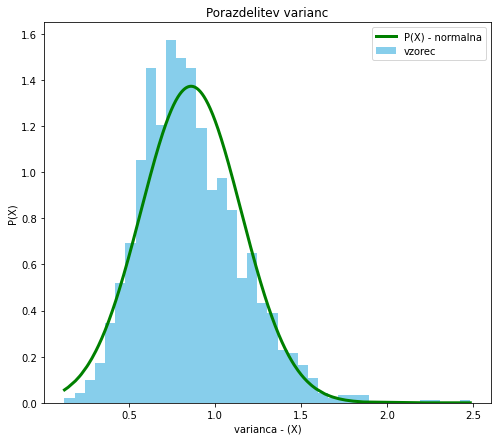

In [11]:
from scipy.stats import multivariate_normal as mvn 

# porazdelitvena funkcija iz ocenjnenih paramterov
P_fit = [mvn.pdf(var, mu_fit, sigma2_fit) for var in variance]


plt.figure(figsize=(8, 7))
plt.hist(np_movie_ratings[:, 0], bins=40, density=True, label="vzorec", color = "skyblue")
plt.plot(variance, P_fit, 'g', label="P(X) - normalna", linewidth=3.0)  

plt.title("Porazdelitev varianc")
plt.ylabel("P(X)")
plt.xlabel("varianca - (X)");
plt.legend();

Vidimo, da se ocenjena normalna porazdelitev vzorcu ne prilega prav dobro, zamaknjena je v desno in malo prenizka.

#### 1.4. vprašanje:

Oceni parametre te porazdelitve s pomočjo postopkov, ki smo jih spoznali na vajah.  Izmed porazdelitev, ki smo jih spoznali na vajah, izberi tisto, ki se podatkom najbolj prilega.    

Odgovor: 

Videli smo, da se vzorcu normalna porazdelitev ne prilega preveč točno, malo je zamaknjena, zato prevrimo, kako se vzorcu prilegajo se druge poraydelitve - **Studentova** in **Beta** porazdelitev.

Najprej izrisemo **Studentovo** porazdlitev.

S pomočjo funkcije student.fit, iz vzorca ocenimo parametre za Studentovo porazdelitev.

Nato s funkcijo student.pdf izračunamo Studentovo porazdelitev.

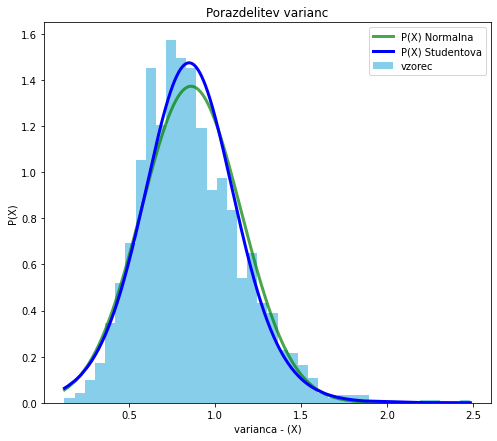

In [12]:
from scipy.stats import t as student 

# ocenimo parametre iz vzrca
pars = student.fit(variance)
# Studentova porazdelitvena funkcija
P_fit_s = [student.pdf(var, *pars) for var in variance ]

plt.figure(figsize=(8, 7))
plt.hist(np_movie_ratings[:, 0], bins=40, density=True, label="vzorec", color = "skyblue")
plt.plot(variance, P_fit, 'g', label="P(X) Normalna", linewidth=3.0, alpha=0.7) 
plt.plot(variance, P_fit_s, 'b', label="P(X) Studentova", linewidth=3.0)  
plt.title("Porazdelitev varianc")
plt.ylabel("P(X)")
plt.xlabel("varianca - (X)");
plt.legend();

Vidimo, da se Studentova porazdelitev prilega vzorcu boje kot Normalna, ampak je se vedno zamaknjena v desno.

Poizkusimo še z **Beta** porazdelitvijo.

S pomočjo funkcije beta.fit, iz vzorca ocenimo parametre za Beta porazdelitev.

Nato s funkcijo beta.pdf izračunamo Beta porazdelitev.

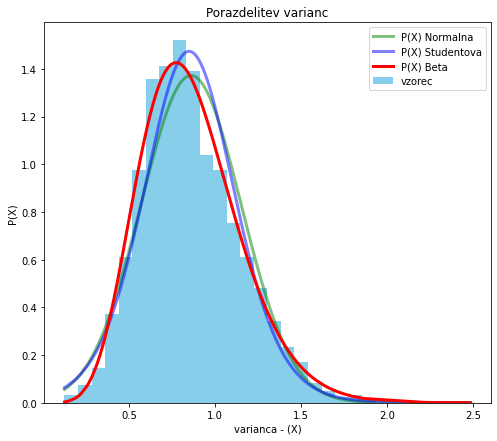

In [13]:
from scipy.stats import beta

# ocenimo parametre iz vzrca
pars_b = beta.fit(variance)
# Beta porazdelitvena funkcija
P_fit_b = [beta.pdf(var, *pars_b) for var in variance ]

plt.figure(figsize=(8, 7))
plt.hist(np_movie_ratings[:, 0], bins=30, density=True, label="vzorec", color = "skyblue")
plt.plot(variance, P_fit, 'g',  label="P(X) Normalna", linewidth=3.0, alpha=0.5) 
plt.plot(variance, P_fit_s, 'b',  label="P(X) Studentova", linewidth=3.0, alpha=0.5)  
plt.plot(variance, P_fit_b, 'r', label="P(X) Beta", linewidth=3.0)  
plt.title("Porazdelitev varianc")
plt.ylabel("P(X)")
plt.xlabel("varianca - (X)")
plt.legend();

Vidimo, da beta porazdelitev odpravi težavo z zamaknjenostjo v desno, kar je bil problem pri drugih 2 porazdelitvah.

Beta porazdelitev se tako najbolje prilega vzorcu.

#### 1.5. vprašanje:

Izpiši filme z vrednostjo naključne spremenljivke, ki spada v zgornjih 5% statistično značilnih primerov. 

Odgovor: 

Za izpis filmov z vrednostjo naključne spremenljivke (variance), ki spadajo v zgornjih 5% statistično značilnih primerov moramo najti primerno mejo (qx). 

p-vrednost je ploščina pod krivuljo P(x) za vse vrednosti, večje od qx.

Vemo, da mora biti izračun p-vrednosti 0.05 - 5%.

Filmi, ki spadajo v zgornjih 4.95% statistično značilnih primerov imajo varianco nad 1.273


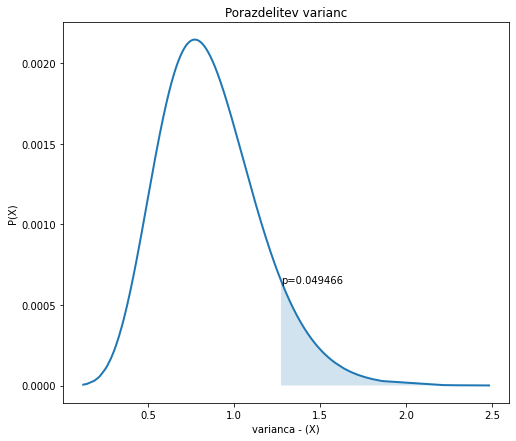

In [14]:
# Meritev, ki bi jo radi statisticno ocenili  
qx = 1.273

# ocenimo parametre iz vzrca
pars_b = beta.fit(variance)

n = variance.shape[0]

# izracunamo dolzino intervala
width = (variance[-1] - variance[0]) / (n-1)

# Izračunamo P(x)
Px = [beta.pdf(var, *pars_b)*width for var in variance]

# Vse vrednosti, ki so vecje ali enake od qx
ltx =  variance[ variance >= qx]      

# Množimo s širino intervala, da dobimo ploščino pod krivuljo
P_ltx = [beta.pdf(x, *pars_b)*width for x in ltx] 
                            
# p-vrednost: ploscina pod krivuljo P(x) za vse vrednosti, vecje od qx
p_value = np.sum(P_ltx)

# Graf funkcije
plt.figure(figsize=(8, 7))
plt.plot(variance, Px, linewidth=2.0)
plt.fill_between(ltx, 0, P_ltx, alpha=0.2)
plt.text(qx, beta.pdf(qx, *pars_b)*width, 
         "p=%f" % p_value,  
         horizontalalignment="left",
         verticalalignment="center",
        )

plt.title("Porazdelitev varianc")
plt.ylabel("P(X)")
plt.xlabel("varianca - (X)")

print("Filmi, ki spadajo v zgornjih", "{0:.2%}".format(p_value), "statistično značilnih primerov imajo varianco nad %.3f" % qx)

Izrišemo beta porazdelitev in pod krivuljo izračunamo ploščino p-vrednost za vse primere nad qx. 

Za mero qx smo vzeli vrednost 1.273, kar pomeni, da filmi z varianco nad 1.273 spadajo v zgornjih 4.95% statistično značilnih primerov.

Nato ta filter uporabimo na podatkih filmov za izpis tistih, ki spadajo v zgornjih 4.97%.

In [15]:
zgornjih_pet = [(var, id1) for var, x, y, id1 in np_movie_ratings if var >= qx]
zgornjih_pet = np.asarray(zgornjih_pet)

print("Filmi, z varianco, ki spadajo v zgornjih 4.95% statistično značilnih primerov.\n")

for var, id1 in zgornjih_pet[:15]:
    print("Movie: ", movies_data[id1][0], "Var: %.3f" % var)

Filmi, z varianco, ki spadajo v zgornjih 4.95% statistično značilnih primerov.

Movie:  Taken (2008) Var: 1.273
Movie:  Despicable Me (2010) Var: 1.280
Movie:  We Were Soldiers (2002) Var: 1.281
Movie:  Blade II (2002) Var: 1.282
Movie:  Before Sunrise (1995) Var: 1.284
Movie:  Man in the Iron Mask, The (1998) Var: 1.285
Movie:  Mission: Impossible II (2000) Var: 1.286
Movie:  Ghost Dog: The Way of the Samurai (1999) Var: 1.287
Movie:  Affair to Remember, An (1957) Var: 1.288
Movie:  Death Becomes Her (1992) Var: 1.289
Movie:  Austin Powers in Goldmember (2002) Var: 1.292
Movie:  A.I. Artificial Intelligence (2001) Var: 1.295
Movie:  Babe: Pig in the City (1998) Var: 1.295
Movie:  Confessions of a Dangerous Mind (2002) Var: 1.297
Movie:  Star Wars: Episode I - The Phantom Menace (1999) Var: 1.299


In [16]:
print("Vseh filmov, ki spadajo v zgornjih 4.95%", "statistično značilnih primerov je %d." % len(zgornjih_pet))

Vseh filmov, ki spadajo v zgornjih 4.95% statistično značilnih primerov je 139.


Glede na mero qx = 1.273, sem variance filtriral in izpisal filme, ki spadajo v zgornjih 4.95% statistično značilnih primerov.

Takih filmov je 139.

#### 2. Gručenje filmov (50%)

Priporočilni sistemi pogosto odkrivajo skupine predmetov (v našem primeru filme), za katere velja visoka medsebojna podobnost.

Poiščite 100 najbolj gledanih filmov. Ali med njimi obstajajo skupine?
Uporabite ustrezen algoritem za gručenje. Na film lahko gledamo kot vektor, kjer je  
število komponent enako številu uporabnikov. 

Vektorji vsebujejo tudi *neznane vrednosti*.
Primer vektorjev za deset filmov prikazuje spodnja tabela.

Algoritme gručenja lahko izvajamo v izvornem prostoru (koordinatni sistem filmi-uporabniki) ali pa filme primerjamo z merami podobnosti, ki smo jih spoznali na vajah. 
Premisli, kateri način je primernejši glede na obliko podatkov.

| x          |Movie                                      | $u_0$ |$u_1$ | $u_2$ | $\cdots$ |
|------------|-------------------------------------------|:-----:|:----:|:------|:--------:|
|$\vec{x_0}$ | Fight Club (1999)                         | ?     | ?    | ?     | $\cdots$ |
|$\vec{x_1}$ | Twelve Monkeys (a.k.a. 12 Monkeys) (1995) | ?     | ?    | 2.5   | $\cdots$ |
|$\vec{x_2}$ | Independence Day (a.k.a. ID4) (1996)      | ?     | ?    | ?     | $\cdots$ |
|$\vec{x_3}$ | Dances with  Wolves (1990)                | 4.0   | ?    | ?     | $\cdots$ |
|$\vec{x_4}$ | Fargo (1996)                              | ?     | ?    | ?     | $\cdots$ |
|$\vec{x_5}$ | Speed (1994)                              | ?     | ?    | ?     | $\cdots$ |
|$\vec{x_6}$ | Apollo 13 (1995)                          | ?     | 2.0  | ?     | $\cdots$ |
|$\vec{x_7}$ | Seven (a.k.a. Se7en) (1995)               | ?     | ?    | ?     | $\cdots$ |
|$\vec{x_8}$ | Sixth Sense, The (1999)                   | 3.0   | ?    | 4.0   | $\cdots$ |
|$\vec{x_9}$ | Aladdin (1992)                            | ?     | ?    | ?     | $\cdots$ |
|$\cdots$    | $\cdots$                                  | $\cdots$ | $\cdots$  | $\cdots$ | $\cdots$ |

#### 2.1. vprašanje:

Utemelji izbiro algoritma in mere podobnosti.

Odgovor: 

Za gručenje bom uporabil metodo sch.linkage iz knjižnjice scipy modula cluster.hierarchy. 

Algoritem sprejme 3 parametre:

**1. Matrika podatkov**

Sestavljena iz filmov in uporabnikovih ocen

**2. Metodo povezovanja**

    Uporabil bom: 
    - metodo "average", ki izračuna povprečno razdaljo med vsemi pari točk, ALI
    - metodo "single", ki kot razdaljo med gručami vzame razdaljo med najbližjimi tockami gruč.

   Za metodo se bom odločil na podlagi ustreznosti (pravilnosti) rezultatov pridobljenih skupin.

**3. Mera razdalje**

Kot mero razdalje bom uporabil **Jaccardov index**. Odločil sem se zato, ker je primeren za uporabo kjer imamo mankajoče vrednosti.
V našem primeru bo veliko mankajočih vrednosti, ker vemo da ni vsak uporabnik ocenil vsakega filma.

**Priprava podatkov**

Za uporabo linkage metode moramo pripraviti matriko filmov in ocen uporabnikov.

Vrstice v matriki bodo predstavljale filme (100), stolpci pa bodo predstavljali uporabnike, ki so ocenjevali fime.

Če uporabnik ni ocenil nekega filma bo vrednost 0 - mankajoča vrednost (uporaba Jaccardovega indexa).

Poiščemo 100 najbolj gledanih filmov (filmov z največ ocenami).

In [17]:
# najdemo 100 najbolj gledanih filmov (sortiramo po stevilu ocen)

def stevilo_ocen(movie):
    ocene = raiting_data[raiting_data[:, 1] == movie, 2]
    return ocene.shape[0]

# izracunamo stevilo ocen za posamezen film
movies_nocen = [(stevilo_ocen(movie), movie) for movie in movies]

# filme sortiramo po stevilu ocen, da lahko dobimo top 100 najbolj gledanih
sorted_movies = sorted(movies_nocen, reverse = True)

In [18]:
top100_dict = {}
top100_movies = []
for st, id1 in sorted_movies[:100]:
    top100_movies.append(id1)
    top100_dict[id1] = movies_data[float(id1)]

V tabelo top100_movies smo shranili 100 najbolj gledanih filmov.

Pripravimo še tabelo vseh uporabnikov, ki so ocenjevali filme. Najprej zberemo vse ocene.

In [19]:
ocene = []
for ocena in raiting_data:
    if(ocena[1] in top100_dict):   
        ocene.append(ocena)
        
ocene = np.asarray(ocene)
ocene.shape[0]
print(ocene)

[[2.000 10.000 4.000 835355493.000]
 [2.000 39.000 5.000 835355604.000]
 [2.000 47.000 4.000 835355552.000]
 ...
 [671.000 4993.000 5.000 1064245483.000]
 [671.000 5349.000 4.000 1065111863.000]
 [671.000 5952.000 5.000 1063502716.000]]


Tabelo z metodo np.unique filtriramo na vse uporabnike, ki so ocenjeali top 100 filmov.

In [20]:
uporabniki = np.unique(ocene[:, 0])

print("Prvih 10 uporabnikov: ", uporabniki[:10])
print("Stevilo uporabnikov: ", uporabniki.shape[0])

Prvih 10 uporabnikov:  [2.000 3.000 4.000 5.000 6.000 7.000 8.000 9.000 10.000 11.000]
Stevilo uporabnikov:  656


Vidimo, da je vseh uporabnikov, ki so ocenjevali top 100 filmov 656, zato bomo zgradili matriko 100 x 656 in jo zapolnili z 0.

In [21]:
matrika_ocen = np.zeros((100, uporabniki.shape[0]), dtype=float)
matrika_ocen

array([[0.000, 0.000, 0.000, ..., 0.000, 0.000, 0.000],
       [0.000, 0.000, 0.000, ..., 0.000, 0.000, 0.000],
       [0.000, 0.000, 0.000, ..., 0.000, 0.000, 0.000],
       ...,
       [0.000, 0.000, 0.000, ..., 0.000, 0.000, 0.000],
       [0.000, 0.000, 0.000, ..., 0.000, 0.000, 0.000],
       [0.000, 0.000, 0.000, ..., 0.000, 0.000, 0.000]])

Iz vseh ocen zgradimo matriko: (filmi x uporabniki)

In [22]:
for ocena in ocene:
    u_index = np.where(uporabniki == ocena[0])[0][0]
    movie_index = np.where(top100_movies == ocena[1])[0][0]
    matrika_ocen[movie_index][u_index] = ocena[2]

In [23]:
print(matrika_ocen)

[[3.000 5.000 5.000 ... 0.000 0.000 5.000]
 [4.000 4.500 5.000 ... 0.000 0.000 4.000]
 [0.000 5.000 0.000 ... 0.000 5.000 5.000]
 ...
 [0.000 0.000 5.000 ... 0.000 0.000 3.000]
 [0.000 0.000 0.000 ... 0.000 0.000 0.000]
 [5.000 0.000 0.000 ... 0.000 0.000 0.000]]


Zgleda vredu, zdaj lahko uporabimo metodo sch.linkag za izračun skupin (gruč).

#### 2.2. vprašanje:

Koliko skupin filmov je med izbranimi? Ali poznamo kvantitativne ocene za različne možnosti razvrščanja v skupine?

Z metodo sch.linkage zgradimo dendrogram. Nato pridobimo napovedi za skupine z metodo sch.fcluster.

Skupine (napovedi) so odvisne od  metode povezovanja, mere razdalje in parametra - t, ki določa razdaljo pri kateri odsekamo dendrogram. 

Te parametre določimo glede na ustreznost (pravilnost) pridobljenih skupin in koeficitent silhuete.

In [24]:
import scipy.cluster.hierarchy as sch
import scipy
from collections import defaultdict

# prerez dendrogram (meja skupin)
t = 0.78
L = sch.linkage(matrika_ocen, method="average", metric="jaccard")   

# predikcije skupin za top 100 filmov
predictions = sch.fcluster(L, t=t, criterion="distance").ravel()

# izpis filmov po skupinah, ki vsebujejo vec kot 2 filma 
skupine_dict = defaultdict(list)
for id1, prediction in list(zip(top100_movies, predictions)):
    skupine_dict[prediction].append(top100_dict[id1])
for skupina in skupine_dict:
    if(len(skupine_dict[skupina]) > 1):
        print("Skupina: ", skupina)
        for movie in skupine_dict[skupina]:
            print(movie[0])
        print("")

Skupina:  54
Star Wars: Episode IV - A New Hope (1977)
Star Wars: Episode V - The Empire Strikes Back (1980)
Star Wars: Episode VI - Return of the Jedi (1983)

Skupina:  55
Raiders of the Lost Ark (Indiana Jones and the Raiders of the Lost Ark) (1981)
Indiana Jones and the Last Crusade (1989)

Skupina:  12
Aladdin (1992)
Lion King, The (1994)
Beauty and the Beast (1991)

Skupina:  40
Lord of the Rings: The Fellowship of the Ring, The (2001)
Lord of the Rings: The Two Towers, The (2002)
Lord of the Rings: The Return of the King, The (2003)

Skupina:  75
Godfather, The (1972)
Godfather: Part II, The (1974)

Skupina:  24
Pretty Woman (1990)
Ghost (1990)

Skupina:  33
Monsters, Inc. (2001)
Finding Nemo (2003)

Skupina:  47
Alien (1979)
Aliens (1986)



Za ocenitev primernosti pridobljenih skupin po gručenju uporabimo koeficient silhuete.

Koeficint silhuete je ocena med -1 (napačno dodeljene skupine) in 1 (zelo goste, dobro ločene skupine).

Koeficient silhuete izračunamo z metodo silhouette_score.

In [25]:
from sklearn.metrics import silhouette_score

score = silhouette_score(matrika_ocen, predictions, metric="jaccard")
print("Koeficient silhuete: %.4f" % score)

Koeficient silhuete: 0.0357


Pri ocenjevanju parametrov za izgradnjo dendrograma sem si pomagal s koeficientom silhuete in ustreznosti končnih skupin.

Poskušal sem z različnimi parametri. 

Ugotovimo, da skupine najbolj primerno razčleni metoda povezovanja "average" in Jaccardov index za mero razdalje.

Razdaljo, pri kateri smo prerezali dendrogramov - t pa je bila najbolj primerna pri 0.78. 

Pri tej kombinaciji parametrov je koeficient silhuete najvišji - 0.0357.

Na koncu dobim 8 napovedanih skupin.

#### 2.3. vprašanje:

Prikaži rezultate z uporabo ustrezne vizualizacije.

Dobljene rezultate vizualiziramo z metodo sch.dendrogram, ki izriše dendrogram in obarva dobljene skupine pri prerezu - t (parameter - color_threshold).

X os predstavlja filme, Y os pa razdalje med skupinami (gručami).

Označimo še prerez dendrograma s črtkano črto.

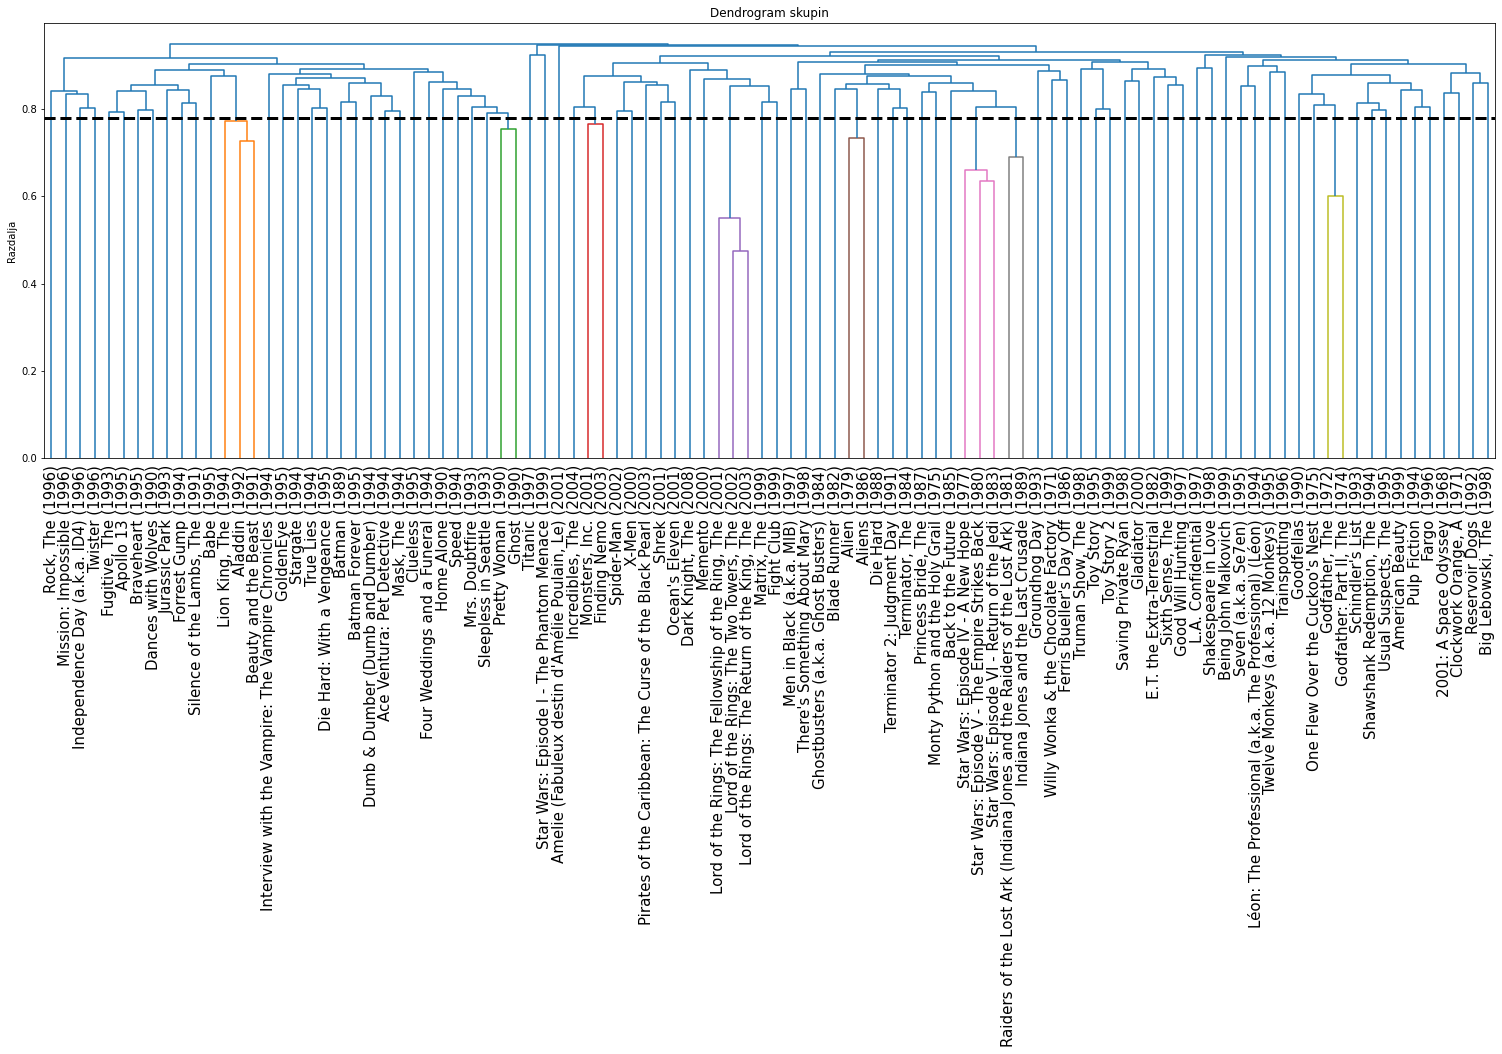

In [26]:
t = 0.78
L = sch.linkage(matrika_ocen, method="average", metric="jaccard")


plt.figure(figsize=(26, 8))
labels = [top100_dict[id1][0] for id1 in top100_movies]
D      = sch.dendrogram(L, labels=labels, leaf_font_size=15, color_threshold=t)
plt.plot([0, 1000], [t, t], "k--", linewidth=3.0)
plt.title("Dendrogram skupin")
plt.ylabel("Razdalja")
plt.show()

#### 2.4. vprašanje:

Komentiraj smiselnost dobljenih rezultatov.

In [27]:
for skupina in skupine_dict:
    if(len(skupine_dict[skupina]) > 1):
        print("Skupina: ", skupina)
        for movie in skupine_dict[skupina]:
            print(movie[0])
        print("")

Skupina:  54
Star Wars: Episode IV - A New Hope (1977)
Star Wars: Episode V - The Empire Strikes Back (1980)
Star Wars: Episode VI - Return of the Jedi (1983)

Skupina:  55
Raiders of the Lost Ark (Indiana Jones and the Raiders of the Lost Ark) (1981)
Indiana Jones and the Last Crusade (1989)

Skupina:  12
Aladdin (1992)
Lion King, The (1994)
Beauty and the Beast (1991)

Skupina:  40
Lord of the Rings: The Fellowship of the Ring, The (2001)
Lord of the Rings: The Two Towers, The (2002)
Lord of the Rings: The Return of the King, The (2003)

Skupina:  75
Godfather, The (1972)
Godfather: Part II, The (1974)

Skupina:  24
Pretty Woman (1990)
Ghost (1990)

Skupina:  33
Monsters, Inc. (2001)
Finding Nemo (2003)

Skupina:  47
Alien (1979)
Aliens (1986)



Dobimo 8 skupin. Zgrajene (napovedane) skupine zgledajo točne. Podobnosti med posameznimi filmi znotraj skupine so velike.

V skupini 54 imamo filme Star Warsa, pomeni, da je velika vrjetnost, da bodo uporabnika pri gledanju filma Start Wars - IV, zanimala tudi druga 2 filma v skupini.

V skupini 55, 75 in 47 imamo film in njihovo nadaljevanje (sequel). 

V skupini 12 imamo Disnijeve risanke.

Podobno kot pri Star Warsu imamo v skupini 40 filme LOTR. 

V skupini 33 imamo animirane filme. 

Pri vseh skupinah lahko opazimo tudi, da so iz podobnega časovnega obdobja (npr. skupina 24 - 1990)